<a href="https://colab.research.google.com/github/MBobie/Public-Figure-Classifier/blob/main/Public_Figure_Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#libraries
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
import os
import shutil
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sn
import joblib
import json
from google.colab.patches import cv2_imshow

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the image file in Google Drive
image_path = '/content/drive/MyDrive/Public Figure Classifier/model/test images/LJ1.jpg'

# Load the image using OpenCV
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is not None:
    print("Image loaded successfully!")
    print("Image dimensions:", img.shape)
else:
    print("Failed to load image. Please check the file path.")
    # Exit if image is not loaded to prevent errors in subsequent code
    raise SystemExit("Image not loaded. Check the path and try again.")

Image loaded successfully!
Image dimensions: (959, 959, 3)


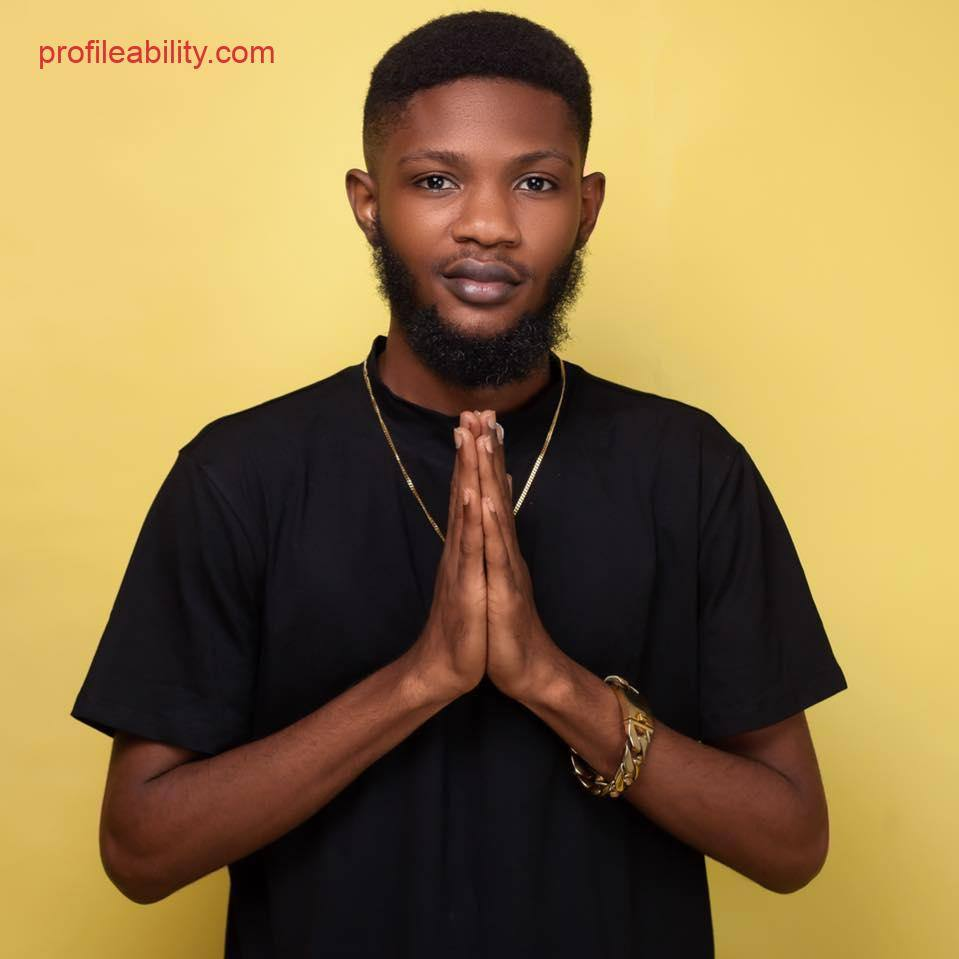

In [ ]:
cv2_imshow(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(959, 959)

In [ ]:
gray

array([[208, 208, 208, ..., 199, 199, 199],
       [208, 208, 208, ..., 199, 199, 199],
       [208, 208, 208, ..., 199, 199, 199],
       ...,
       [173, 173, 173, ..., 170, 170, 170],
       [173, 173, 173, ..., 170, 170, 170],
       [173, 173, 173, ..., 170, 170, 170]], dtype=uint8)

Displaying grayscale image:


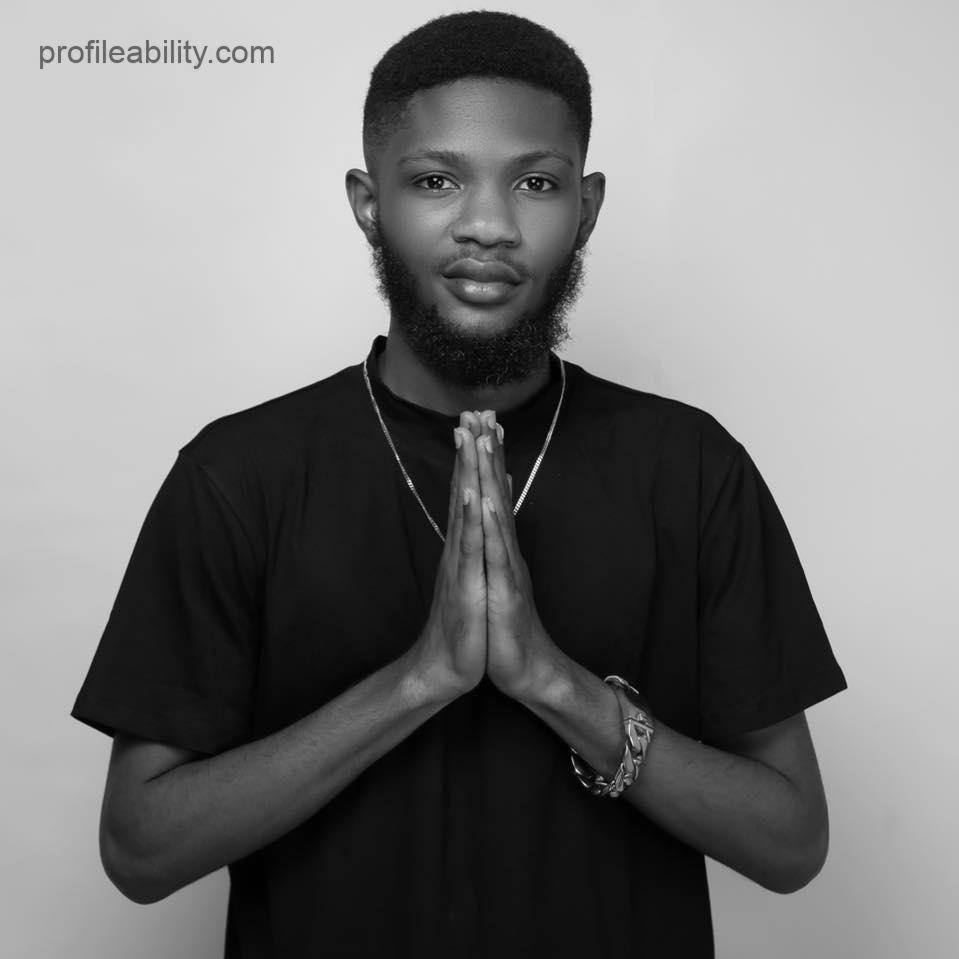

In [ ]:
# Convert image to grayscale for face and eye detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
print("Displaying grayscale image:")
cv2_imshow(gray)

Number of faces detected: 1
Displaying image with detected faces and eyes:


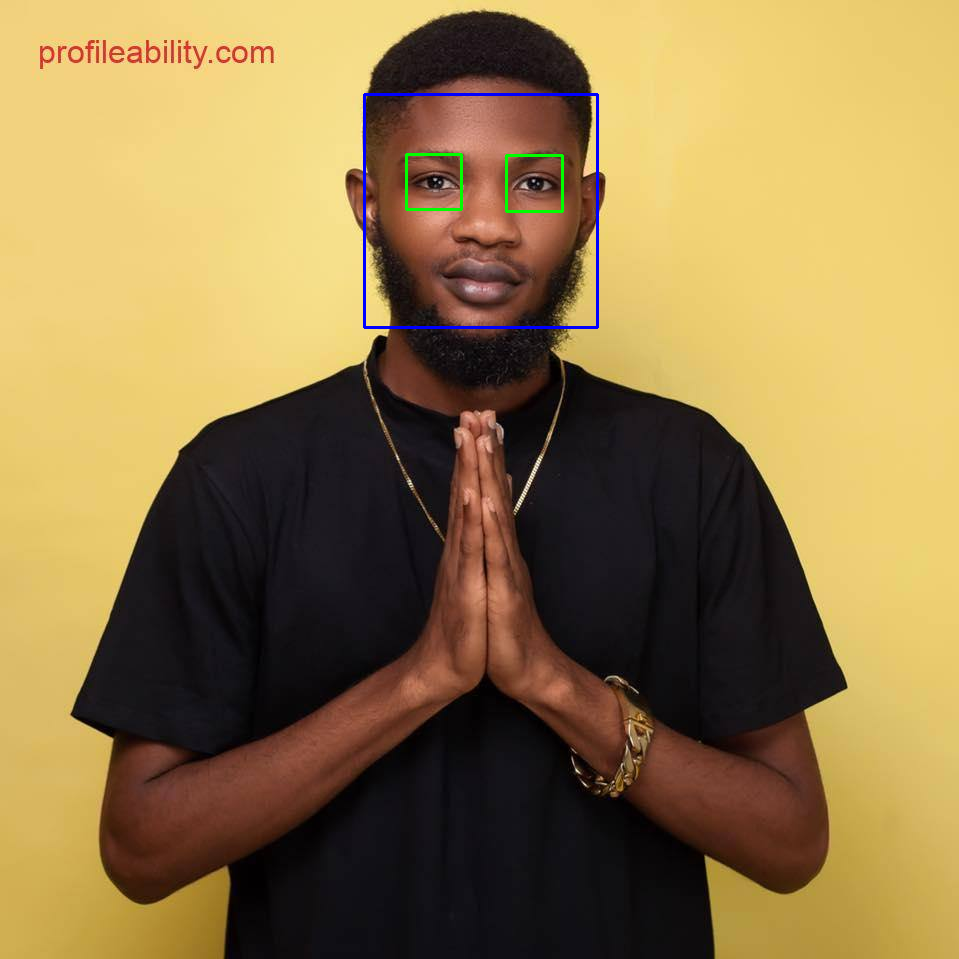

In [ ]:
# Paths to custom Haar cascade XML files
face_cascade_path = '/content/drive/MyDrive/Public Figure Classifier/model/opencv/haarcascades/haarcascade_frontalface_default.xml'
eye_cascade_path = '/content/drive/MyDrive/Public Figure Classifier/model/opencv/haarcascades/haarcascade_eye.xml'

# Load the Haar cascade classifiers
face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Check if faces were detected and print the result
if len(faces) == 0:
    print("No faces detected.")
else:
    print(f"Number of faces detected: {len(faces)}")
    # Draw rectangles around detected faces and eyes on the original image
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue rectangle for face
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)  # Green rectangle for eyes

# Display the original image with detected faces and eyes
print("Displaying image with detected faces and eyes:")
cv2_imshow(img)

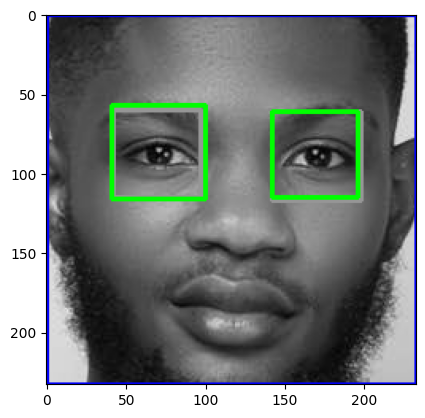

In [ ]:
# Assuming 'faces' and 'eyes' have been detected
if len(faces) > 0:
    # Just take the first detected face for demonstration
    x, y, w, h = faces[0]
    # Crop the face from the original (colored) image
    cropped_face = img[y:y+h, x:x+w]

    # Convert the cropped face to grayscale
    cropped_face_gray = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)
    # Convert the grayscale cropped face back to BGR so we can draw colored rectangles
    cropped_face_colored = cv2.cvtColor(cropped_face_gray, cv2.COLOR_GRAY2BGR)

    # Detect eyes within the cropped grayscale face
    eyes = eye_cascade.detectMultiScale(cropped_face_gray)
    # Draw rectangles around detected eyes
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(cropped_face_colored, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)  # Green rectangle for eyes

    # Draw a blue rectangle for the face on the cropped colored image
    cv2.rectangle(cropped_face_colored, (0, 0), (w, h), (255, 0, 0), 2)  # Blue rectangle for face

    # Display the cropped face with colored rectangles
    plt.imshow(cv2.cvtColor(cropped_face_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with Matplotlib
    plt.show()
else:
    print("No faces detected.")


In [ ]:
cropped_img = np.array(roi_color)
cropped_img.shape

(233, 233, 3)

In [ ]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

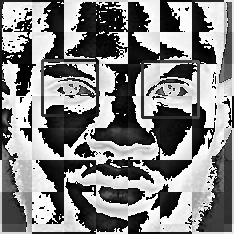

In [ ]:
im_har = w2d(cropped_img,'db1',5)
cv2_imshow(im_har)

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face found
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            # Return the cropped face if at least two eyes are detected
            roi_color = img[y:y + h, x:x + w]
            return roi_color

    # Return None if conditions are not met
    return None

In [ ]:
def display_image(image):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Image not available or conditions not met for display.")

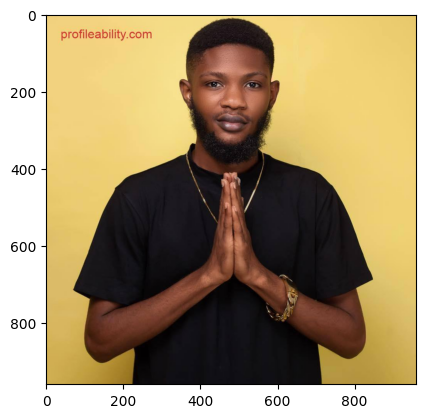

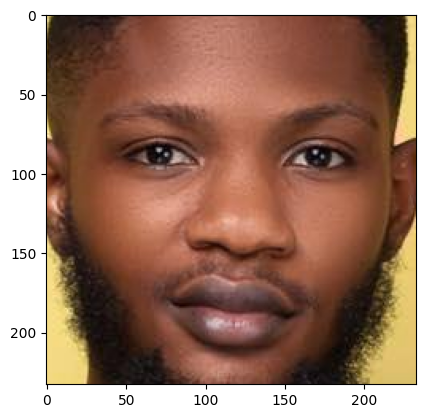

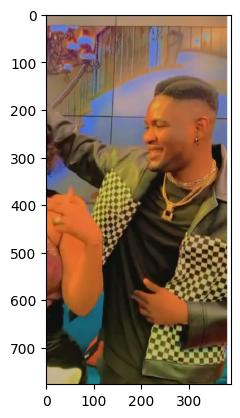

In [ ]:
original_image = cv2.imread('/content/drive/MyDrive/Public Figure Classifier/model/test images/LJ1.jpg')
display_image(original_image)

cropped_image = get_cropped_image_if_2_eyes('/content/drive/MyDrive/Public Figure Classifier/model/test images/LJ1.jpg')
display_image(cropped_image)

org_image_obstructed = cv2.imread('/content/drive/MyDrive/Public Figure Classifier/model/test images/L1.png')
display_image(org_image_obstructed)

In [ ]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('/content/drive/MyDrive/Public Figure Classifier/model/test images/L1.png')
cropped_image_no_2_eyes

In [ ]:
path_to_data = "/content/drive/MyDrive/Public Figure Classifier/model/dataset/"
path_to_cr_data = "/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/"

In [ ]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/Public Figure Classifier/model/dataset/Noni Madueke',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Cristiano Ronaldo',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Donald Trump',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Kennedy Agyapong',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Seth Rollins',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Lyrical Joe',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Dwayne Johnson',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Lionel Messi',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Sarkodie',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Elon Musk',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Serwaa Amihere',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped']

In [ ]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [ ]:
cropped_image_dirs = []
Public_Figure_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    Public_Figure_name = img_dir.split('/')[-1]
    print(Public_Figure_name)

    Public_Figure_file_names_dict[Public_Figure_name] = []

    allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    for entry in os.scandir(img_dir):
        ext = os.path.splitext(entry.path)[1].lower()
        if ext in allowed_extensions:
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, Public_Figure_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ", cropped_folder)

                cropped_file_name = Public_Figure_name + str(count) + ".png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                Public_Figure_file_names_dict[Public_Figure_name].append(cropped_file_path)
                count += 1


Noni Madueke
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke
Cristiano Ronaldo
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Cristiano Ronaldo
Donald Trump
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Donald Trump
Kennedy Agyapong
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Kennedy Agyapong
Seth Rollins
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Seth Rollins
Lyrical Joe
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Lyrical Joe
Dwayne Johnson
Generating cropped images in folder:  /content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Dwayne Johnson
Lionel Messi
Generating cropped images in 

In [ ]:
img_dirs

['/content/drive/MyDrive/Public Figure Classifier/model/dataset/Noni Madueke',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Cristiano Ronaldo',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Donald Trump',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Kennedy Agyapong',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Seth Rollins',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Lyrical Joe',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Dwayne Johnson',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Lionel Messi',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Sarkodie',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Elon Musk',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/Serwaa Amihere',
 '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped']

In [ ]:
Public_Figure_file_names_dict = {}
for img_dir in cropped_image_dirs:
    Public_Figure_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    Public_Figure_file_names_dict[Public_Figure_name] = file_list
Public_Figure_file_names_dict

{'Noni Madueke': ['/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke/Noni Madueke1.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke/Noni Madueke2.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke/Noni Madueke3.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke/Noni Madueke4.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Noni Madueke/Noni Madueke5.png'],
 'Cristiano Ronaldo': ['/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Cristiano Ronaldo/Cristiano Ronaldo1.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Cristiano Ronaldo/Cristiano Ronaldo2.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Cristiano Ronaldo/Cristiano Ronaldo3.png',
  '/content/drive/MyDrive/Public Figure Classifier/model/dataset/cropped/Cristiano R

In [ ]:
class_dict = {}
count = 0
for Public_Figure_name in Public_Figure_file_names_dict.keys():
    class_dict[Public_Figure_name] = count
    count = count + 1
class_dict

{'Noni Madueke': 0,
 'Cristiano Ronaldo': 1,
 'Donald Trump': 2,
 'Kennedy Agyapong': 3,
 'Seth Rollins': 4,
 'Lyrical Joe': 5,
 'Dwayne Johnson': 6,
 'Lionel Messi': 7,
 'Sarkodie': 8,
 'Elon Musk': 9,
 'Serwaa Amihere': 10}

In [ ]:
X, y = [], []
for Public_Figure_name, training_files in Public_Figure_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[Public_Figure_name])

In [ ]:
len(X[0])

4096

In [ ]:
X[0]

array([[ 16],
       [ 10],
       [ 11],
       ...,
       [  8],
       [ 24],
       [188]], dtype=uint8)

In [ ]:
y[0]

0

In [ ]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(505, 4096)

Data Cleaning Process is Complete!

Refining SVM with an RBF kernel using heuristic fine-tuning for training.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7401574803149606

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.70      0.58      0.64        12
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.79      0.96      0.86        46
           5       0.60      1.00      0.75         3
           6       0.50      0.53      0.51        17
           7       1.00      0.62      0.77         8
           8       0.00      0.00      0.00         1
           9       0.74      0.74      0.74        23
          10       0.90      1.00      0.95         9

    accuracy                           0.74       127
   macro avg       0.47      0.49      0.47       127
weighted avg       0.69      0.74      0.71       127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using GridSearch to explore various models with different parameters. Our objective is to identify the optimal model with finely tuned parameters.

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,model,best_score,best_params
0,svm,0.780491,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.624421,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.772526,{'logisticregression__C': 5}


from matplotlib import pyplot as plt
df['best_score'].plot(kind='hist', bins=20, title='best_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['best_score'].plot(kind='line', figsize=(8, 4), title='best_score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='best_score', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.8031496062992126

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.5826771653543307

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7874015748031497

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  8,  0,  0,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  2,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 44,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  2, 13,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  2,  0,  1,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  4,  0,  0, 17,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]])

Text(158.22222222222223, 0.5, 'Truth')

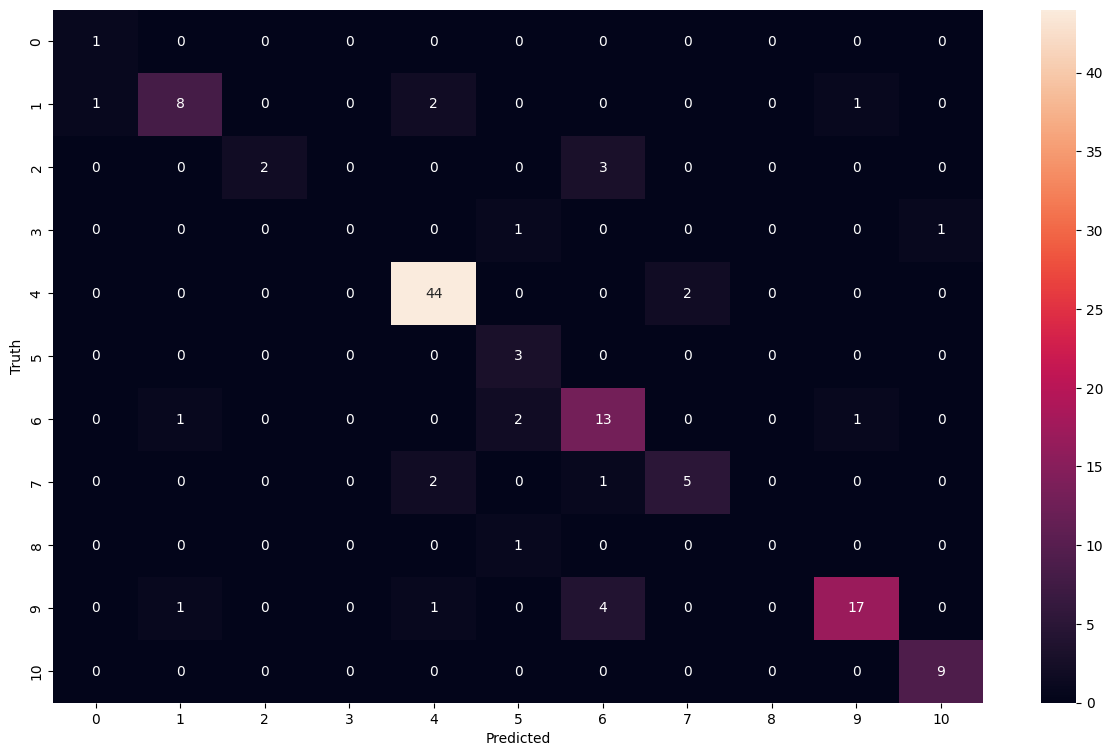

In [ ]:
plt.figure(figsize = (15,9))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
class_dict

{'Noni Madueke': 0,
 'Cristiano Ronaldo': 1,
 'Donald Trump': 2,
 'Kennedy Agyapong': 3,
 'Seth Rollins': 4,
 'Lyrical Joe': 5,
 'Dwayne Johnson': 6,
 'Lionel Messi': 7,
 'Sarkodie': 8,
 'Elon Musk': 9,
 'Serwaa Amihere': 10}

In [ ]:
#save trained model
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [ ]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [ ]:
!pip install jupyter-dash

In [ ]:
!pip install flask flask-ngrok

In [3]:
!pip install flask-ngrok


Flask App

In [7]:
# Global variables to hold your artifacts, ensure these are defined at the top of util.py
__class_name_to_number = {}
__class_number_to_name = {}

def load_saved_artifacts():
    print("loading saved artifacts...start")
    global __class_name_to_number, __class_number_to_name

    # Path to your artifacts in Google Drive
    artifacts_path = '/content/drive/MyDrive/Public Figure Classifier/server/artifacts/'

    # Adjust the file paths
    with open(artifacts_path + 'class_dictionary.json', 'r') as f:
        __class_name_to_number = json.load(f)
        __class_number_to_name = {v: k for k, v in __class_name_to_number.items()}

    print("loading saved artifacts...done")

# Ensure you have a function to classify images that uses these loaded artifacts
def classify_image(image_data):
    # Your image classification logic here, using the loaded artifacts
    # This is just a placeholder for your actual image classification logic
    return {"status": "success", "message": "image classified", "predictions": {}}

from flask import Flask, request, jsonify
import util
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Enables ngrok when the app is run

@app.route('/classify_image', methods=['GET', 'POST'])
def classify_image():
    image_data = request.form['image_data']
    response = jsonify(util.classify_image(image_data))
    response.headers.add('Access-Control-Allow-Origin', '*')
    return response

if __name__ == "__main__":
    print("Starting Python Flask Server")
    util.load_saved_artifacts()  # This will now correctly load from your specified Google Drive path
    app.run()  # No need to specify port in this case


Starting Python Flask Server
loading saved artifacts...start


FileNotFoundError: [Errno 2] No such file or directory: './artifacts/class_dictionary.json'